# <div align="center"><h1>Graph Classification : Protein</h1></div>

In [1]:
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import mlflow
import numpy as np
import torch.nn as nn

import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Loading the PROTEIN dataset

In [2]:
dataset = dgl.data.TUDataset("PROTEINS_full")

In [3]:
NUM_FEATURES = 29

### Visualization of a Protein

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

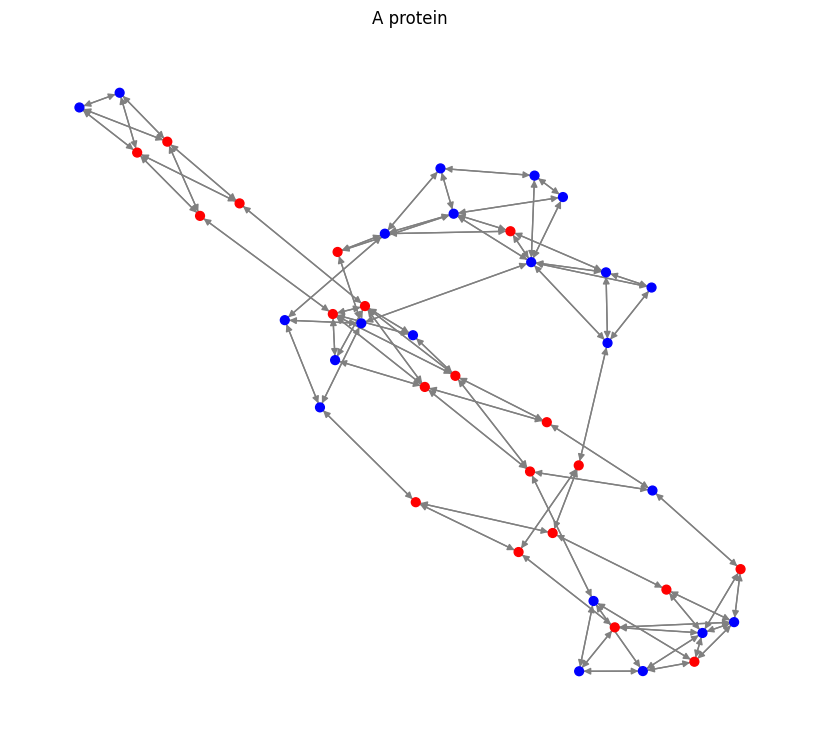

In [5]:
g1 = dataset[0]
nodes_label = g1[0].ndata["node_labels"].numpy().squeeze()
label_to_color = {0:"blue", 1:"red"}
nodes_colors = [label_to_color[l] for l in nodes_label]
display_options = {
    'node_color' : nodes_colors,
    'node_size' : 40,
    'width' : 1,
    'edge_color':"gray"
}

g1_graphic = dgl.to_networkx(g1[0])
plt.figure(figsize=[8,7])
nx.draw(g1_graphic, **display_options)
plt.title('A protein')
plt.show()

### Define GNN Models

In [7]:
from dgl.nn import GATConv, GATv2Conv
from dgl.nn import GraphConv
from dgl.nn import SumPooling

class GAT(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, h_feats, num_heads=1, residual=True)
        self.conv2 = GATConv(h_feats, h_feats, num_heads=1)
        self.pool = SumPooling()
        self.linear1 = nn.Linear(h_feats, 128)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 64)
    
    def forward(self, g, feats):
        h = F.relu(self.layer1(g, feats))
        h = F.relu(self.layer2(g, h))
        h = self.pool(g, h)
        return self.linear(h)

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.pool = SumPooling()
        self.linear1 = nn.Linear(h_feats, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 64)
    
    def forward(self, g, feats):
        h = F.relu(self.conv1(g, feats))
        h = F.relu(self.conv2(g, h))
        h = self.pool(g, h)
        h = F.relu(self.linear1(h))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        return F.softmax(h)

In [8]:
class Evaluator():
    def __init__(self):
        self._total_loss = 0
        self._prediction = []
        self._ground_truth = []

    def reset_metrics(self):
        self._total_loss = 0
        self._prediction.clear()
        self._ground_truth.clear()
 
    def update_metrics(self, pred, true, loss=None):
        if loss:
            self._total_loss += loss
        for y_pred, y_true in zip(pred, true):
            self._prediction.append(y_pred)
            self._ground_truth.append(y_true)

    def get_metrics(self, metric="accuracy"):
        metrics = []
        if self._total_loss != 0:
            metrics.append(self._total_loss)
        if metric == "f1":
            metrics.append(f1_score(self._ground_truth, self._prediction))
        else:
            metrics.append(accuracy_score(self._ground_truth, self._prediction))
        return metrics

    def get_confusion_matrix(self):
        confmat = confusion_matrix(self._ground_truth, self._prediction)
        confmat_display = ConfusionMatrixDisplay(confmat)
        return confmat_display

In [9]:
def suppress_zero_degree(batch):
    graphs = dgl.unbatch(batch)
    new_graphs = [dgl.add_self_loop(g) for g in graphs]
    return dgl.batch(new_graphs)

def dataset_to_dataloaders(dataset, batch_size):
    X,Y = zip(*[dataset[i] for i in range(len(dataset))])
    X_indices = torch.arange(len(dataset))
    train_indices, test_indices, y_train, _ = train_test_split(X_indices, Y, test_size=0.2, random_state=42, shuffle=True, stratify=Y)
    train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)
    
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    
    train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=False)
    val_dataloader = GraphDataLoader(dataset, sampler=val_sampler, batch_size=batch_size, drop_last=False)
    test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=batch_size, drop_last=False)

    return train_dataloader, val_dataloader, test_dataloader

def train(model, optimizer, dataset, batch_size=5, epochs=10, metric="accuracy"):
    train_data, val_data, test_data = dataset_to_dataloaders(dataset, batch_size)
    evaluator = Evaluator()
    print(f"Metric used : {metric}")
    for epoch in range(epochs):
        evaluator.reset_metrics()
        for graph_batch, labels in train_data:
            new_batch = suppress_zero_degree(graph_batch)
            labels = labels.squeeze().float()
            #Forward
            outputs = model(new_batch, new_batch.ndata["node_attr"].float()).squeeze()
            loss = F.binary_cross_entropy_with_logits(outputs, labels)
            #Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #Accuracy
            prediction = (torch.sigmoid(outputs) > 0.5).float()
            evaluator.update_metrics(prediction, labels, loss.item())

        avg_loss, train_accuracy = evaluator.get_metrics(metric)
        avg_loss /= len(train_data)

        evaluator.reset_metrics()
        for graph_batch, labels in val_data:
            new_batch = suppress_zero_degree(graph_batch)
            labels = labels.squeeze().float()
            outputs = model(new_batch, new_batch.ndata["node_attr"].float()).squeeze()
            prediction = (torch.sigmoid(outputs) > 0.5).float()
            evaluator.update_metrics(prediction, labels)

        val_accuracy = evaluator.get_metrics(metric)[0]

        print(f"Epoch {epoch+1}/{epochs}, loss: {avg_loss:.2f} - Train Metric: {train_accuracy:.2f} - Val Metric: {val_accuracy:.2f}")
    
    evaluator.reset_metrics()
    for graph_batch, labels in test_data:
            new_batch = suppress_zero_degree(graph_batch)
            labels = labels.squeeze().float()
            outputs = model(new_batch, new_batch.ndata["node_attr"].float()).squeeze()
            prediction = (torch.sigmoid(outputs) > 0.5).float()
            evaluator.update_metrics(prediction, labels)

    test_accuracy = evaluator.get_metrics(metric)[0]
    print(f"\nTest accuracy: {test_accuracy:.2f}")
    confmat = evaluator.get_confusion_matrix()
    confmat.plot()
    plt.show()

    return round(test_accuracy, 2)

In [11]:
def mlflow_run(name, tag, model, gcn_params, train_params, dataset):
    with mlflow.start_run(run_name=name):
        mlflow.log_params(gcn_params)
        mlflow.log_params(train_params)
        mlflow.set_tag("Model", tag)
        optimizer = torch.optim.Adam(model.parameters(), lr=train_params["lr"], 
                                     weight_decay=train_params["weight_decay"])
        test_metric = train(model, optimizer, dataset, batch_size=train_params["batch"],
                            epochs=train_params["epoch"], metric=train_params["metric"])
        mlflow.log_metric(train_params["metric"], test_metric)     

Metric used : f1


/home/babatunde/Documents/venv_ML/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, loss: 1.48 - Train Metric: 0.52 - Val Metric: 0.45
Epoch 2/10, loss: 0.73 - Train Metric: 0.58 - Val Metric: 0.66
Epoch 3/10, loss: 0.64 - Train Metric: 0.62 - Val Metric: 0.60
Epoch 4/10, loss: 0.59 - Train Metric: 0.63 - Val Metric: 0.63
Epoch 5/10, loss: 0.60 - Train Metric: 0.66 - Val Metric: 0.72
Epoch 6/10, loss: 0.58 - Train Metric: 0.65 - Val Metric: 0.70
Epoch 7/10, loss: 0.57 - Train Metric: 0.66 - Val Metric: 0.65
Epoch 8/10, loss: 0.59 - Train Metric: 0.63 - Val Metric: 0.71
Epoch 9/10, loss: 0.60 - Train Metric: 0.65 - Val Metric: 0.69
Epoch 10/10, loss: 0.58 - Train Metric: 0.62 - Val Metric: 0.65

Test accuracy: 0.58


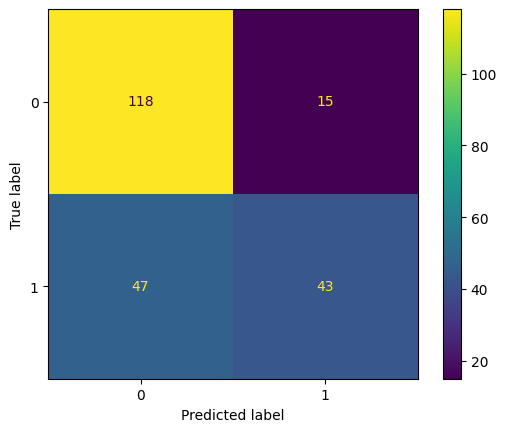

🏃 View run GCN 2 at: http://127.0.0.1:5000/#/experiments/472643957914153805/runs/211c581ddcdc46be97af9b38532e4609
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/472643957914153805


In [13]:
model_params = {
    "conv1" : "GraphConv(29,128)",
    "conv2" : "GraphConv(128,128)",
    "pool" : "SumPooling()",
    "linear1" : "Linear(128,256)",
    "linear2" : "Linear(256,128)",
    "linear3" : "Linear(128,64)" 
}

train_params = {
    "batch" : 5,
    "epoch" : 50,
    "lr" : 1e-4,
    "weight_decay" : 5e-4,
    "metric" : "f1"
}

model = GCN(NUM_FEATURES, 128, 1)
mlflow_run("GCN 3","GCN", model, model_params, train_params, dataset)

Metric used : f1
Epoch 1/10, loss: 0.45 - Train Metric: 0.46 - Val Metric: 0.49
Epoch 2/10, loss: 0.17 - Train Metric: 0.58 - Val Metric: 0.55
Epoch 3/10, loss: 0.18 - Train Metric: 0.56 - Val Metric: 0.59
Epoch 4/10, loss: 0.18 - Train Metric: 0.60 - Val Metric: 0.54
Epoch 5/10, loss: 0.19 - Train Metric: 0.62 - Val Metric: 0.60
Epoch 6/10, loss: 0.15 - Train Metric: 0.65 - Val Metric: 0.54
Epoch 7/10, loss: 0.19 - Train Metric: 0.61 - Val Metric: 0.63
Epoch 8/10, loss: 0.19 - Train Metric: 0.63 - Val Metric: 0.62
Epoch 9/10, loss: 0.17 - Train Metric: 0.65 - Val Metric: 0.62
Epoch 10/10, loss: 0.22 - Train Metric: 0.63 - Val Metric: 0.63

Test accuracy: 0.58


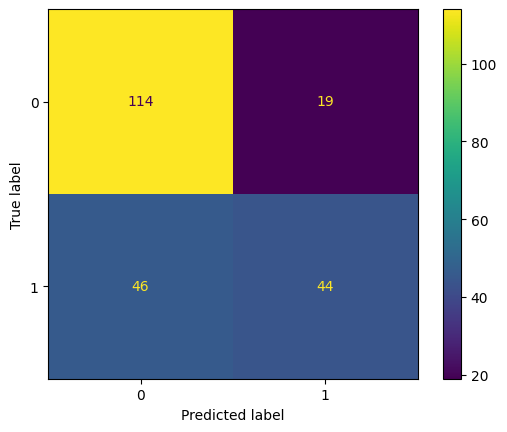

🏃 View run GAT-Multi ? at: http://127.0.0.1:5000/#/experiments/472643957914153805/runs/13f3adf23fc54b1c9bd07718eb2eb3ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/472643957914153805


In [103]:
model_params = {
    "layer1" : "GATConv(29,64,num_heads=4), residual=True",
    #"layer2" : "GATConv(64,64,num_heads=1)",
    "layer2" : "AvgPooling()",
    "layer3" : "Linear(64,1)"    
}

train_params = {
    "batch" : 5,
    "epoch" : 10,
    "lr" : 1e-4,
    "weight_decay" : 5e-4,
    "metric" : "f1"
}

model = GAT(NUM_FEATURES, 128, 1, 4)
mlflow_run("GAT-Multi ?", "GAT", model, model_params, train_params, dataset)